In [1]:
import sqlite3
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [2]:
RT_LIMIT_LOWER = 4340  # RT range in the database
RT_LIMIT_UPPER = 4580
RT_BASE_PEAK_WIDTH_SECS = 30.0  # assumption about base peak width in RT
MS1_CE = 10

In [3]:
BASE_NAME = "/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
ALLPEPTIDES_FILENAME = '/Users/darylwilding-mcbride/Downloads/maxquant_results/txt/allPeptides.txt'
# BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
# ALLPEPTIDES_FILENAME = '/home/ubuntu/maxquant_results/txt/allPeptides.txt'

CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)

In [4]:
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-4340-4580/HeLa_20KInt.sqlite'

In [5]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
ms2_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy <> {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
db_conn.close()

In [6]:
ms1_frame_properties_df.head()

,frame_id,retention_time_secs
0,40411,4340.340330
1,40422,4341.521415
2,40433,4342.702923
3,40444,4343.883324
4,40455,4345.067491


In [7]:
ms2_frame_properties_df.head()

,frame_id,retention_time_secs
0,40408,4340.019894
1,40409,4340.127084
2,40410,4340.233855
3,40412,4340.446655
4,40413,4340.554812


In [8]:
ms1_frame_delay = ms1_frame_properties_df.iloc[1].retention_time_secs - ms1_frame_properties_df.iloc[0].retention_time_secs
ms1_frame_delay

1.1810854877303427

In [9]:
len(ms1_frame_properties_df)

203

In [10]:
# get all the isolation windows
isolation_window_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/isolation_window_df.pkl')

In [11]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,CollisionEnergy,Precursor
0,3,507,532,742.744835,2.427448,36.96,1
1,3,549,574,709.235759,2.092358,36.96,2
2,3,602,627,594.235088,2.000000,36.96,3
3,3,643,668,503.527768,2.000000,36.96,4
4,3,684,709,552.063870,2.000000,31.92,5


In [12]:
# add-in the retention time for the isolation windows and filter out the window not in range
isolation_window_df = pd.merge(isolation_window_df, ms2_frame_properties_df, how='left', left_on=['Frame'], right_on=['frame_id'])
isolation_window_df.drop(['frame_id', 'CollisionEnergy'], axis=1, inplace=True)
isolation_window_df.dropna(subset=['retention_time_secs'], inplace=True)
isolation_window_df['mz_lower'] = isolation_window_df.IsolationMz - (isolation_window_df.IsolationWidth / 2)
isolation_window_df['mz_upper'] = isolation_window_df.IsolationMz + (isolation_window_df.IsolationWidth / 2)
isolation_window_df['rt_lower'] = isolation_window_df.retention_time_secs - RT_BASE_PEAK_WIDTH_SECS
isolation_window_df['rt_upper'] = isolation_window_df.retention_time_secs + RT_BASE_PEAK_WIDTH_SECS

In [13]:
# filter out isolation windows that don't fit in the database subset we have loaded
isolation_window_df = isolation_window_df[(isolation_window_df.rt_lower >= RT_LIMIT_LOWER) & (isolation_window_df.rt_upper <= RT_LIMIT_UPPER)]

In [14]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper,rt_lower,rt_upper
315657,40688,219,244,1106.675230,3.0,148941,4370.101926,1105.175230,1108.175230,4340.101926,4400.101926
315658,40688,287,312,987.488407,3.0,148938,4370.101926,985.988407,988.988407,4340.101926,4400.101926
315659,40688,344,369,922.491024,3.0,148930,4370.101926,920.991024,923.991024,4340.101926,4400.101926
315660,40688,386,411,884.941548,3.0,148942,4370.101926,883.441548,886.441548,4340.101926,4400.101926
315661,40688,434,459,876.400632,3.0,148943,4370.101926,874.900632,877.900632,4340.101926,4400.101926


Select one of the precursors

In [15]:
print("There are {} precursor isolation windows.".format(len(isolation_window_df)))

There are 17860 precursor isolation windows.


In [1326]:
ISOLATION_WINDOW_IDX = 8089
window_df = isolation_window_df.iloc[ISOLATION_WINDOW_IDX]

In [1327]:
# PRECURSOR_ID = 154951
# window_df = isolation_window_df[isolation_window_df.Precursor == PRECURSOR_ID].iloc[0]

In [1328]:
window_df

Frame                   41440.000000
ScanNumBegin              529.000000
ScanNumEnd                554.000000
IsolationMz               637.196938
IsolationWidth              2.000000
Precursor              153212.000000
retention_time_secs      4450.910639
mz_lower                  636.196938
mz_upper                  638.196938
rt_lower                 4420.910639
rt_upper                 4480.910639
Name: 323746, dtype: float64

In [1329]:
mz_lower = window_df.mz_lower
mz_upper = window_df.mz_upper
scan_width = int(window_df.ScanNumEnd - window_df.ScanNumBegin)
scan_lower = int(window_df.ScanNumBegin - scan_width)
scan_upper = int(window_df.ScanNumEnd + scan_width)
rt_lower = window_df.rt_lower
rt_upper = window_df.rt_upper
precursor_id = int(window_df.Precursor)

In [1330]:
# get the ms1 frame IDs
ms1_frame_ids = tuple(ms1_frame_properties_df.astype(int).values[:,0])


In [1331]:
# load the cube's raw ms1 points
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(mz_lower, mz_upper, scan_lower, scan_upper, rt_lower, rt_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [1332]:
len(raw_points_df)

28144

In [1333]:
raw_points_df.intensity.max()

5870

In [1334]:
raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
0,41170,636.208854,553,19,4421.919624
1,41170,636.236694,518,26,4421.919624
2,41170,636.252603,549,21,4421.919624
3,41170,636.268513,517,11,4421.919624
4,41170,636.272490,551,41,4421.919624


In [1335]:
MZ_MIN = mz_lower
MZ_MAX = mz_upper
MZ_BIN_WIDTH = 0.1

In [1336]:
bins = np.arange(start=MZ_MIN, stop=MZ_MAX+MZ_BIN_WIDTH, step=MZ_BIN_WIDTH)  # go slightly wider to accomodate the maximum value


In [1337]:
bins

array([636.19693781, 636.29693781, 636.39693781, 636.49693781,
       636.59693781, 636.69693781, 636.79693781, 636.89693781,
       636.99693781, 637.09693781, 637.19693781, 637.29693781,
       637.39693781, 637.49693781, 637.59693781, 637.69693781,
       637.79693781, 637.89693781, 637.99693781, 638.09693781,
       638.19693781, 638.29693781])

In [1338]:
MZ_BIN_COUNT = len(bins)

In [1339]:
# initialise an array of lists to hold the m/z and intensity values allocated to each bin
mz_values_array = np.empty(MZ_BIN_COUNT, dtype=np.object)
for idx in range(MZ_BIN_COUNT):
    mz_values_array[idx] = []


In [1340]:
# gather the m/z values into bins
for r in zip(raw_points_df.mz, raw_points_df.intensity):
    mz = r[0]
    intensity = int(r[1])
    if (mz >= MZ_MIN) and (mz <= MZ_MAX): # it should already but just to be sure
        mz_array_idx = int(np.digitize(mz, bins)) # in which bin should this mz go
        mz_values_array[mz_array_idx].append((mz, intensity))

In [1341]:
import peakutils

In [1342]:
# compute the intensity-weighted m/z centroid and the summed intensity of the bins
peaks = []
for bin_idx in range(MZ_BIN_COUNT):
    if len(mz_values_array[bin_idx]) > 0:
        mz_values_for_bin = np.array([ list[0] for list in mz_values_array[bin_idx]])
        intensity_values_for_bin = np.array([ list[1] for list in mz_values_array[bin_idx]]).astype(int)
        mz_centroid = peakutils.centroid(mz_values_for_bin, intensity_values_for_bin)
        summed_intensity = intensity_values_for_bin.sum()
        peaks.append((mz_centroid,summed_intensity))

In [1343]:
peaks

[(636.2714884020947, 31952),
 (636.3275145405626, 711859),
 (636.4619644252298, 9618),
 (636.5777190190605, 91613),
 (636.6328634622145, 127318),
 (636.7587520818887, 27422),
 (636.8634257346097, 1136442),
 (636.9649472462008, 155841),
 (637.0566103911937, 51380),
 (637.1248580266218, 32892),
 (637.2750492259514, 65246),
 (637.3638130012824, 926110),
 (637.4231895309271, 12254),
 (637.5653558596503, 59605),
 (637.6375613237939, 92934),
 (637.7688538753978, 23776),
 (637.8626660624541, 478753),
 (637.9612587008176, 35494),
 (638.0638932016059, 53226),
 (638.1300989701502, 15667)]

In [1344]:
peaks_df = pd.DataFrame(peaks, columns=['mz_centroid','summed_intensity'])

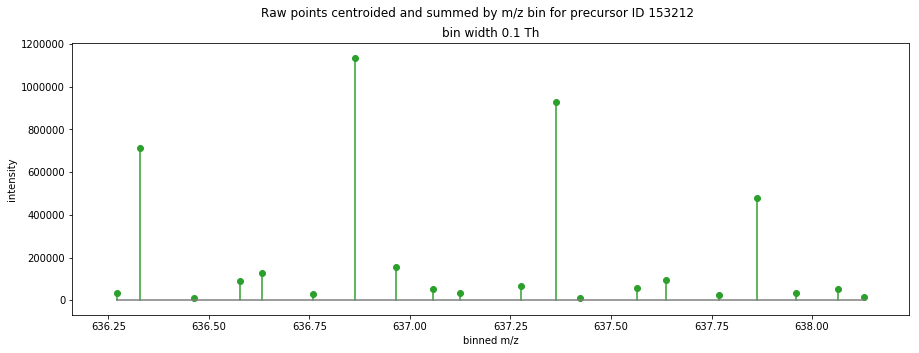

In [1345]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(peaks_df.mz_centroid, peaks_df.summed_intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by m/z bin for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MZ_BIN_WIDTH))
plt.show()

In [1346]:
PROTON_MASS = 1.0073  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.


In [1347]:
from ms_deisotope import deconvolute_peaks, averagine, scoring

# see https://github.com/mobiusklein/ms_deisotope/blob/ee4b083ad7ab5f77722860ce2d6fdb751886271e/ms_deisotope/deconvolution/api.py#L17
deconvoluted_peaks, _priority_targets = deconvolute_peaks(peaks, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)


In [1348]:
peaks_l = []
for peak in deconvoluted_peaks:
    # discard a monoisotopic peak that has a second isotope with intensity of 1 (rubbish value)
    if ((len(peak.envelope) > 1) and (peak.envelope[1][1] > 1)):
        peaks_l.append((peak.mz, peak.neutral_mass, peak.intensity, peak.score, peak.signal_to_noise))
        print("{}\n".format(peak))

deconvoluted_peaks_df = pd.DataFrame(peaks_l, columns=['mz','neutral_mass','intensity','score','SN'])
# 'neutral mass' is the zero charge M, so we add the proton mass to get M+H (the monoisotopic mass)
deconvoluted_peaks_df['m_plus_h'] = deconvoluted_peaks_df.neutral_mass + PROTON_MASS


DeconvolutedPeak(a_to_a2_ratio=13.66201139407719, area=97198.0, average_mass=635.7659923472531, charge=1, chosen_for_msms=False, envelope=[(636.2715, 31952.00), (637.2750, 19894.01), (638.2769, 1.00)], full_width_at_half_max=0.01, index=0|0, intensity=51846.01190349287, most_abundant_mass=635.2642119353247, mz=636.2714884020947, neutral_mass=635.2642119353247, score=249.12756229022494, signal_to_noise=48599.0)

DeconvolutedPeak(a_to_a2_ratio=3.6910085273013875, area=92668.0, average_mass=1272.0192483743, charge=2, chosen_for_msms=False, envelope=[(636.7588, 27422.00), (637.2750, 7367.30), (637.7683, 1.00)], full_width_at_half_max=0.01, index=1|2, intensity=34789.30271031348, most_abundant_mass=1271.5029512302374, mz=636.7654990375978, neutral_mass=1271.5164451416556, score=92.98836825239894, signal_to_noise=46334.0)

DeconvolutedPeak(a_to_a2_ratio=3.691008527301388, area=2541305.0, average_mass=1272.7120502653574, charge=2, chosen_for_msms=False, envelope=[(636.8634, 1136442.00), (637.

In [1349]:
deconvoluted_peaks_df

,mz,neutral_mass,intensity,score,SN,m_plus_h
0,636.271488,635.264212,5.184601e+04,249.127562,48599.000000,636.271512
1,636.765499,1271.516445,3.478930e+04,92.988368,46334.000000,1272.523745
2,636.862136,1271.709718,2.541305e+06,2286.092019,847101.666667,1272.717018
3,637.063678,1272.112804,1.642110e+05,389.475833,54737.000000,1273.120104
4,637.126744,1272.238935,1.058051e+05,272.020260,47164.333333,1273.246235
5,637.275049,1272.535546,8.902200e+04,252.046007,44511.000000,1273.542846
6,636.632863,1906.876761,3.760930e+05,757.156955,125364.333333,1907.884061


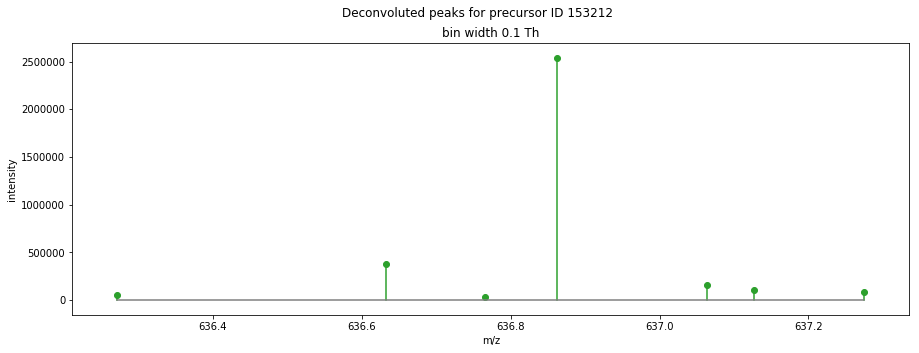

In [1350]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(deconvoluted_peaks_df.mz, deconvoluted_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Deconvoluted peaks for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MZ_BIN_WIDTH))
plt.show()

For each monoisotopic peak found, find its apex in RT and mobility

In [1375]:
# assume the high score is for the monoisotopic peak
monoisotopic_mz = deconvoluted_peaks_df.iloc[2].mz

In [1376]:
monoisotopic_mz

636.8621355823824

Get the raw points for the monoisotopic peak

In [1377]:
MZ_TOLERANCE_PPM = 20
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

In [1378]:
monoisotopic_mz_ppm_tolerance = monoisotopic_mz * MZ_TOLERANCE_PERCENT / 100
monoisotopic_mz_lower = monoisotopic_mz - monoisotopic_mz_ppm_tolerance
monoisotopic_mz_upper = monoisotopic_mz + monoisotopic_mz_ppm_tolerance

In [1379]:
monoisotopic_raw_points_df = raw_points_df[(raw_points_df.mz >= monoisotopic_mz_lower) & (raw_points_df.mz <= monoisotopic_mz_upper)]

In [1380]:
monoisotopic_raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
79,41170,636.853320,567,79,4421.919624
80,41170,636.853320,568,129,4421.919624
81,41170,636.857299,531,9,4421.919624
82,41170,636.857299,579,52,4421.919624
83,41170,636.861278,554,59,4421.919624


Collapsing the summed points onto the RT dimension

In [1381]:
rt_df = monoisotopic_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()

In [1382]:
peaks_threshold = 0.3
peaks_idx = peakutils.indexes(rt_df.intensity.values, thres=peaks_threshold, min_dist=10)
if len(peaks_idx) == 0:
    peaks_threshold -= 0.1
    peaks_idx = peakutils.indexes(rt_df.intensity.values, thres=peaks_threshold, min_dist=10)
peaks_df = rt_df.iloc[peaks_idx].copy()

In [1383]:
peaks_df

,frame_id,retention_time_secs,intensity
36,41566,4464.423259,15477


In [1384]:
peaks_df['fragmentation_rt_delta'] = abs(window_df.retention_time_secs - peaks_df.retention_time_secs)

In [1385]:
peaks_df

,frame_id,retention_time_secs,intensity,fragmentation_rt_delta
36,41566,4464.423259,15477,13.51262


In [1386]:
# get the peak closest to the fragmentation event
peaks_df.loc[peaks_df.fragmentation_rt_delta.idxmin()]

frame_id                  41566.000000
retention_time_secs        4464.423259
intensity                 15477.000000
fragmentation_rt_delta       13.512620
Name: 36, dtype: float64

In [1387]:
# index of the closest peak
peak_idx = peaks_df.fragmentation_rt_delta.idxmin()
peak_idx

36

In [1388]:
valleys_idx = peakutils.indexes(-rt_df.intensity.values, thres=0.6, min_dist=RT_BASE_PEAK_WIDTH_SECS/20)
valleys_df = rt_df.iloc[valleys_idx].copy()

In [1389]:
valleys_df

,frame_id,retention_time_secs,intensity
4,41214,4426.643707,299
8,41258,4431.368938,570
10,41280,4433.733502,477
12,41302,4436.095270,891
17,41357,4441.995797,321
21,41401,4446.722907,496
25,41445,4451.447545,1168
27,41467,4453.805803,1692
31,41511,4458.525167,1525
46,41676,4476.228771,1081


In [1390]:
valleys_idx

array([ 4,  8, 10, 12, 17, 21, 25, 27, 31, 46])

In [1391]:
# find the closest valley above the peak
if max(valleys_idx) > peak_idx:
    valley_idx_above = valleys_idx[valleys_idx > peak_idx].min()
else:
    valley_idx_above = -1

In [1392]:
# find the closest valley below the peak
if min(valleys_idx) < peak_idx:
    valley_idx_below = valleys_idx[valleys_idx < peak_idx].max()
else:
    valley_idx_below = -1

In [1393]:
print("{},{}".format(valley_idx_below, valley_idx_above))

31,46


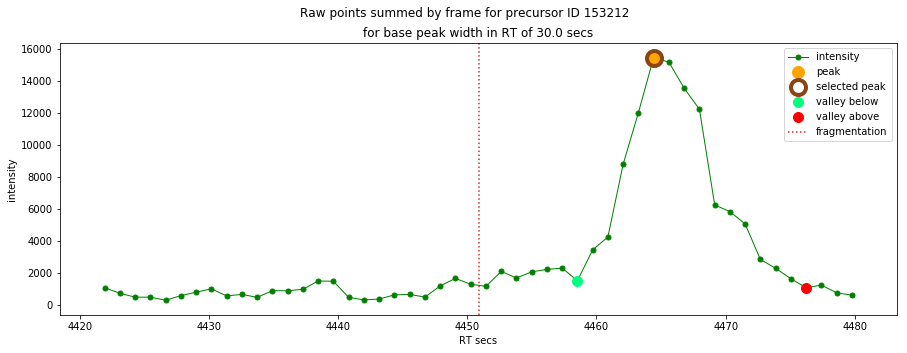

In [1394]:
f, ax = plt.subplots()
ax.plot(rt_df.retention_time_secs, rt_df.intensity, marker='o', color='green', linestyle='-', linewidth=1, ms=5)
ax.plot(peaks_df.retention_time_secs, peaks_df.intensity, marker='o', color='orange', linestyle='', markeredgewidth=3, ms=10, label='peak')
ax.plot(peaks_df.loc[peak_idx].retention_time_secs, peaks_df.loc[peak_idx].intensity, marker='o', markerfacecolor='none', markeredgecolor='saddlebrown', linestyle='', markeredgewidth=4, ms=15, label='selected peak')
if valley_idx_below != -1:
    ax.plot(valleys_df.loc[valley_idx_below].retention_time_secs, valleys_df.loc[valley_idx_below].intensity, marker='o', color='springgreen', linestyle='', markeredgewidth=1, ms=10, label='valley below')
if valley_idx_above != -1:
    ax.plot(valleys_df.loc[valley_idx_above].retention_time_secs, valleys_df.loc[valley_idx_above].intensity, marker='o', color='red', linestyle='', markeredgewidth=1, ms=10, label='valley above')
plt.axvline(x=window_df.retention_time_secs, linestyle=':', color='tab:red', label='fragmentation')
plt.legend(loc='best')
plt.xlabel('RT secs')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points summed by frame for precursor ID {}'.format(precursor_id))
plt.title('for base peak width in RT of {} secs'.format(RT_BASE_PEAK_WIDTH_SECS))
plt.margins(0.06)
plt.show()

Collapsing the summed points onto the mobility dimension

In [1395]:
# constrain the RT to the peak width estimated in the previous step
if valley_idx_below != -1:
    rt_lower = valleys_df.loc[valley_idx_below].retention_time_secs
    print("updating RT to be above {}".format(rt_lower))
    monoisotopic_raw_points_df = monoisotopic_raw_points_df[monoisotopic_raw_points_df.retention_time_secs >= rt_lower]

updating RT to be above 4458.525166869978


In [1396]:
# constrain the RT to the peak width estimated in the previous step
if valley_idx_above != -1:
    rt_upper = valleys_df.loc[valley_idx_above].retention_time_secs
    print("updating RT to be below {}".format(rt_upper))
    monoisotopic_raw_points_df = monoisotopic_raw_points_df[monoisotopic_raw_points_df.retention_time_secs <= rt_upper]

updating RT to be below 4476.2287711842455


In [1397]:
scan_df = monoisotopic_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()

In [1399]:
centroid_scan = peakutils.centroid(scan_df.scan, scan_df.intensity)

In [1400]:
centroid_scan

544.9568175096125

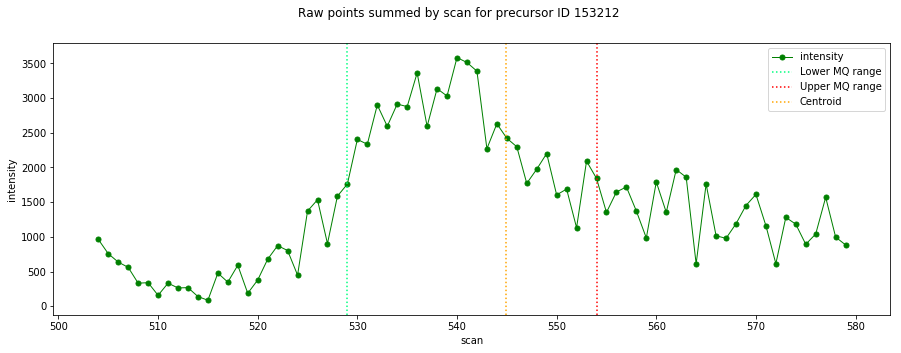

In [1401]:
f, ax = plt.subplots()
ax.plot(scan_df.scan, scan_df.intensity, marker='o', color='green', linestyle='-', linewidth=1, ms=5)
# ax.plot(peaks_df.retention_time_secs, peaks_df.intensity, marker='o', color='orange', linestyle='', markeredgewidth=3, ms=10, label='peak')
plt.axvline(x=window_df.ScanNumBegin, linestyle=':', color='springgreen', label='Lower MQ range')
plt.axvline(x=window_df.ScanNumEnd, linestyle=':', color='red', label='Upper MQ range')
plt.axvline(x=centroid_scan, linestyle=':', color='orange', label='Centroid')
plt.legend(loc='best')
plt.xlabel('scan')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points summed by scan for precursor ID {}'.format(precursor_id))
# plt.title('RT width {} secs'.format(2*RT_BASE_PEAK_WIDTH_SECS))
plt.margins(0.06)
plt.show()